## Введение

К нашей IT-компании обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. Наша компания решила, что использование двух моделей машинного обучения позволит точно отобрать коров подходящих под заданные параметры. Для этого нужно провести тщательную работу с данными, натренировать на них модели и получить результат. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
!pip install phik
import phik 

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


## Загрузка данных

In [2]:
ferma = pd.read_csv('/datasets/ferma_main.csv', sep=';')
dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
cow_to_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';')

display(ferma.head())
display(dad.head())
display(cow_to_buy.head())

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


При чтении файла, было замечено, что использовался другой разделитель. Не "," как обычно, а ";" что было учтено в функции read_csv.

In [3]:
print(ferma.isna().sum())
print(dad.isna().sum())
print(cow_to_buy.isna().sum())

id                                       0
Удой, кг                                 0
ЭКЕ (Энергетическая кормовая единица)    0
Сырой протеин, г                         0
СПО (Сахаро-протеиновое соотношение)     0
Порода                                   0
Тип пастбища                             0
порода папы_быка                         0
Жирность,%                               0
Белок,%                                  0
Вкус молока                              0
Возраст                                  0
dtype: int64
id          0
Имя Папы    0
dtype: int64
Порода                     0
Тип пастбища               0
порода папы_быка           0
Имя_папы                   0
Текущая_жирность,%         0
Текущий_уровень_белок,%    0
Возраст                    0
dtype: int64


In [4]:
print(ferma.duplicated().sum())
print(dad.duplicated().sum())
print(cow_to_buy.duplicated().sum())

5
0
4


В датасетах ferma и cow - 5 и 4 явных дубликатов соответственно, удалим их на этапе предобработки.

**Вывод:**


На данном этапе были загружены три датасета, содержащих различную информацию о фермах, коровах и молоке. Из-за нестандартного разделителя, в функции read_csv, был использован sep с указанием нужного разделителя. При первичном осмотре данных можно отметить некррекное название колонок, которые должны быть приведены к соответсвующему формату на этапе предобработки, отсутствие пропусков в данных, явные дубликаты в первом и третьем датафрейме, аномальное значние в столбце с удоем, а также различная запись одинаковых данных в таблицах ferma и cow. 

##  Предобработка данных

In [5]:
ferma = ferma.merge(dad)
ferma['id'] = ferma['id'].astype('int')
ferma

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет,Буйный
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет,Соловчик
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет,Барин
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет,Буйный
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет,Барин
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет,Барин
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет,Барин
632,628,5746,"13,8",1994,"0,89",РефлешнСоверинг,Равнинное,Соверин,"3,64","3,077",вкусно,более_2_лет,Барин


Присоединил таблицу dad к таблице ferma, потому что она содержит дополнительную информацию про отцов коров с фермы.

In [6]:
ferma.columns = ['id', 'milk_yield_kg', 'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'breed', 'pasture_type',
                 'dads_breed', 'fat_content', 'protein_content', 'milk_flavour', 'age', 'dads_name']
ferma

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет,Буйный
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет,Соловчик
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет,Барин
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет,Буйный
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет,Барин
630,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет,Барин
631,627,5970,"14,4",1837,"0,88",РефлешнСоверинг,Холмистое,Соверин,"3,64","3,075",не вкусно,более_2_лет,Барин
632,628,5746,"13,8",1994,"0,89",РефлешнСоверинг,Равнинное,Соверин,"3,64","3,077",вкусно,более_2_лет,Барин


In [7]:
dad.columns = ['id', 'dads_name']
dad

,id,dads_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


In [8]:
cow_to_buy.columns = ['breed', 'pasture_type', 'dads_breed', 'dads_name', 'fat_content', 'protein_content', 'age']
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,"3,63","3,053",менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,57","3,079",более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,079",менее_2_лет


In [9]:
ferma['pasture_type'] = ferma['pasture_type'].str.lower()
ferma.head()

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет,Буйный
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет,Соловчик
2,3,5810,14,1854,"0,885",РефлешнСоверинг,холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет,Барин
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет,Буйный
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет,Барин


Изменили названия столбцов на корректные, привели данные в столбце с информацией о пастбищах к нижнему регистру, чтобы не было расхождений с датафреймом cow_to_buy.

In [10]:
display(ferma[ferma['milk_yield_kg'] > 10000])
ferma[ferma['milk_yield_kg'] > 10000] = ferma['milk_yield_kg'].mean()
ferma['milk_yield_kg'].describe()

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
16,17,45616,"11,5",1675,"0,93",Вис Бик Айдиал,холмистое,Айдиалл,"3,22","3,076",вкусно,более_2_лет,Буйный


count     634.000000
mean     6124.834425
std       473.804112
min      5204.000000
25%      5751.750000
50%      6130.500000
75%      6500.250000
max      7222.000000
Name: milk_yield_kg, dtype: float64

Устранили аномальное значение заменив его на среднее.

In [11]:
def strin_to_flot(seria):
    seria = seria.str.replace(',', '.')
    seria = seria.astype('float')
    return seria

In [12]:
#начал использовать функцию, но если запускать код с этой функцией, то будет выдавать ошибку,
#потому что str.replace не может работать с float, поэтому я закоментировал работу с функцией после первого запуска,
#чтобы не провоцировать возникновение ошибки. Если запускаете весь код еще раз, то просто закомментируйте эти функции и все будет работать корректно.

ferma['energy_feed_unit'] = strin_to_flot(ferma['energy_feed_unit'])

ferma['sugar_protein_ratio'] = strin_to_flot(ferma['sugar_protein_ratio'])

ferma['fat_content'] = strin_to_flot(ferma['fat_content'])

ferma['protein_content'] = strin_to_flot(ferma['protein_content'])

cow_to_buy['fat_content'] = strin_to_flot(cow_to_buy['fat_content'])

cow_to_buy['protein_content'] = strin_to_flot(cow_to_buy['protein_content'])

print(ferma.info())
cow_to_buy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 0 to 633
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   634 non-null    float64
 1   milk_yield_kg        634 non-null    float64
 2   energy_feed_unit     633 non-null    float64
 3   crude_protein_g      634 non-null    float64
 4   sugar_protein_ratio  633 non-null    float64
 5   breed                634 non-null    object 
 6   pasture_type         634 non-null    object 
 7   dads_breed           634 non-null    object 
 8   fat_content          633 non-null    float64
 9   protein_content      633 non-null    float64
 10  milk_flavour         634 non-null    object 
 11  age                  634 non-null    object 
 12  dads_name            634 non-null    object 
dtypes: float64(7), object(6)
memory usage: 69.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (tot

In [13]:
display(ferma[ferma['energy_feed_unit'].isna()==True])
ferma = ferma.dropna()

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
16,6187.025237,6187.025237,NaN,6187.025237,NaN,6187.025237,6187.025237,6187.025237,NaN,NaN,6187.025237,6187.025237,6187.025237


В датасетах ferma и cow_to_buy данные в столбцах изменены на корректные. В ferma строка с некорректными данными удалена.

In [14]:
ferma = ferma.drop_duplicates()
ferma = ferma.reset_index(drop=True)
ferma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628 entries, 0 to 627
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   628 non-null    float64
 1   milk_yield_kg        628 non-null    float64
 2   energy_feed_unit     628 non-null    float64
 3   crude_protein_g      628 non-null    float64
 4   sugar_protein_ratio  628 non-null    float64
 5   breed                628 non-null    object 
 6   pasture_type         628 non-null    object 
 7   dads_breed           628 non-null    object 
 8   fat_content          628 non-null    float64
 9   protein_content      628 non-null    float64
 10  milk_flavour         628 non-null    object 
 11  age                  628 non-null    object 
 12  dads_name            628 non-null    object 
dtypes: float64(7), object(6)
memory usage: 63.9+ KB


Ликвидировали дубликаты в первом датасете

In [15]:
ferma['pasture_type'] = ferma['pasture_type'].replace(['равнинные'], 'равнинное', regex=True)

В датасете по разному записывались одинаковые типы пастбищ. Иногда было записано как равнинные, а иногда как равнинное. Устранил данную проблему.

При изучении данных, заметил, что породы коров записаны как "Вис Бик Айдиал" и "РефлешнСоверинг", а породы их отцов как "Айдиал" и "Соверин", поискав информацию в интернете, я пришел к выводу, что разницы между ними нет, это просто другая запись. Приведем породы отцов к общему с породами коров виду.

In [16]:
ferma['dads_breed'] = ferma['dads_breed'].replace(['Айдиал', 'Айдиалл'], 'Вис Бик Айдиал')
ferma['dads_breed'] = ferma['dads_breed'].replace('Соверин', 'РефлешнСоверинг')
ferma

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625.0,6812.0,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
624,626.0,5513.0,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.073,вкусно,менее_2_лет,Барин
625,627.0,5970.0,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.64,3.075,не вкусно,более_2_лет,Барин
626,628.0,5746.0,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.077,вкусно,более_2_лет,Барин


In [17]:
cow_to_buy['dads_breed'] = cow_to_buy['dads_breed'].replace('Айдиал', 'Вис Бик Айдиал')
cow_to_buy['dads_breed'] = cow_to_buy['dads_breed'].replace('Соверин', 'РефлешнСоверинг')
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет


**Вывод:**
    
В разделе предобработки были изменены названия колонок, ликвидированы дубликаты, аномальные значения заменены на среднее, тип данных в некоторых столбцах изменен на корректный, устранены различия в записи одинаковых данных. Также к таблице ferma была присоединена таблица dad.

## Исследовательский анализ данных

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield_kg, dtype: float64


<AxesSubplot:title={'center':'Значения удоя'}, xlabel='Удой', ylabel='Количество'>

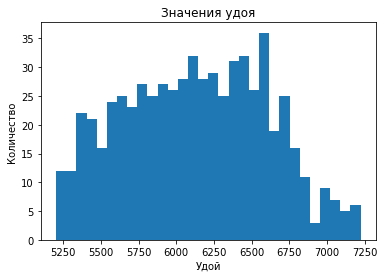

In [18]:
print(ferma['milk_yield_kg'].describe())
plot1 = ferma['milk_yield_kg'].plot(kind='hist',bins = 30, title='Значения удоя')
plt.xlabel("Удой")
plt.ylabel("Количество")
plot1

Удой у фермерских коров находится в диапозоне от 5204кг до 7222кг. Распределение данных об удое напоминает нормальное распределение, что свойственно для такого типа данных. Средний удой - 6126.067966 кг.

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: energy_feed_unit, dtype: float64


<AxesSubplot:title={'center':'Значения энергетической кормовой единицы'}, xlabel='Энергетическая кормовая единица', ylabel='Количество'>

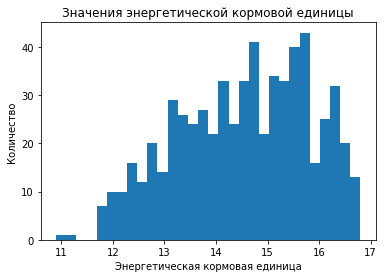

In [19]:
print(ferma['energy_feed_unit'].describe())
plot2 = ferma['energy_feed_unit'].plot(kind='hist',bins = 30, title='Значения энергетической кормовой единицы')
plt.xlabel("Энергетическая кормовая единица")
plt.ylabel("Количество")
plot2

Минимальное значение - 10.9

Максимальное значение - 16.8

Среднее значение - 14.54

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: crude_protein_g, dtype: float64


<AxesSubplot:title={'center':'Значения сырого протеина'}, xlabel='Сырой протеин г.', ylabel='Количество'>

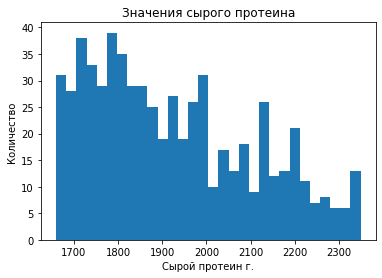

In [20]:
print(ferma['crude_protein_g'].describe())
plot3 = ferma['crude_protein_g'].plot(kind='hist',bins = 30, title='Значения сырого протеина')
plt.xlabel("Сырой протеин г.")
plt.ylabel("Количество")
plot3

Минимальное значение - 1660

Максимальное значение - 2349

Среднее значение - 1923.75

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: sugar_protein_ratio, dtype: float64


<AxesSubplot:title={'center':'Сахарно-протеиновое соотношение'}, xlabel='Сахарно-протеиновое соотношение', ylabel='Количество'>

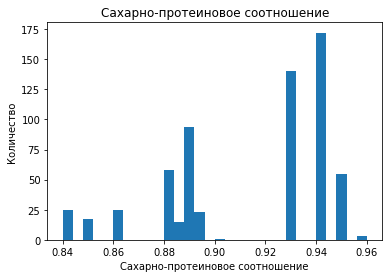

In [21]:
print(ferma['sugar_protein_ratio'].describe())
plot4 = ferma['sugar_protein_ratio'].plot(kind='hist',bins = 30, title='Сахарно-протеиновое соотношение')
plt.xlabel("Сахарно-протеиновое соотношение")
plt.ylabel("Количество")
plot4

Из гистограммы можно отметить, что элементов с большими значениями больше чем со средними и маленькими. 

Минимальное значение - 0.84

Максимальное значение - 0.96

Среднее значение - 0.913089

Вис Бик Айдиал     372
РефлешнСоверинг    256
Name: breed, dtype: int64


<AxesSubplot:title={'center':'Разные породы коров, которые уже на ферме'}, ylabel='breed'>

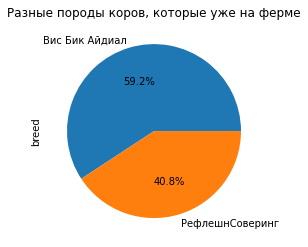

In [22]:
breed_count = ferma.breed.value_counts()
print(breed_count)
breed_count.plot(kind='pie', title='Разные породы коров, которые уже на ферме', autopct='%1.1f%%')

Коров породы Вис Бик Айдиал в полтора раза больше, чем породы РефлешнСоверинг. Первых - 59.2%, вторых - 40.8%.

холмистое    350
равнинное    278
Name: pasture_type, dtype: int64


<AxesSubplot:title={'center':'Разные типы пастбищ'}, ylabel='pasture_type'>

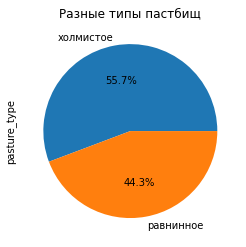

In [23]:
pasture_count = ferma.pasture_type.value_counts()
print(pasture_count)
pasture_count.plot(kind='pie', title='Разные типы пастбищ', autopct='%1.1f%%')

Коров породы с холмистым типом пастбищ - 55.7%, с равнинным - 44.3%.

Вис Бик Айдиал     317
РефлешнСоверинг    311
Name: dads_breed, dtype: int64


<AxesSubplot:title={'center':'Разные породы отцов коров, которые уже на ферме'}, ylabel='dads_breed'>

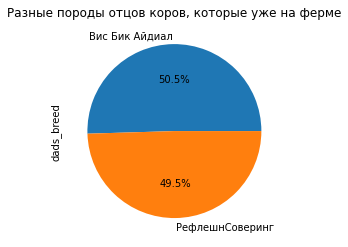

In [24]:
dads_breed_count = ferma.dads_breed.value_counts()
print(dads_breed_count)
dads_breed_count.plot(kind='pie', title='Разные породы отцов коров, которые уже на ферме', autopct='%1.1f%%')

Породы отцов коров представлены в приблизительно равных количествах.

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_content, dtype: float64


<AxesSubplot:title={'center':'Жирность в %'}, xlabel='Жирность в %', ylabel='Количество'>

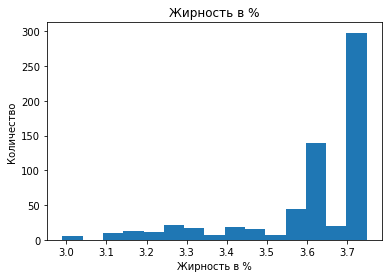

In [25]:
print(ferma['fat_content'].describe())
plot5 = ferma['fat_content'].plot(kind='hist',bins = 15, title='Жирность в %')
plt.xlabel("Жирность в %")
plt.ylabel("Количество")
plot5

Самая популярная жирность находится около 3.7%

Минимальное значение - 2.99

Максимальное значение - 3.75

Среднее значение - 3.604268

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein_content, dtype: float64


<AxesSubplot:title={'center':'Содержание белка в %'}, xlabel='Содержание белка в %', ylabel='Количество'>

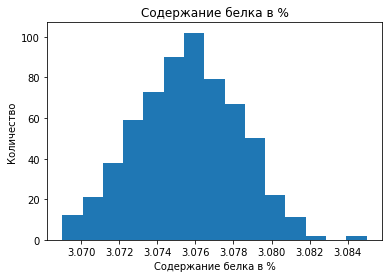

In [26]:
print(ferma['protein_content'].describe())
plot6 = ferma['protein_content'].plot(kind='hist',bins = 15, title='Содержание белка в %')
plt.xlabel("Содержание белка в %")
plt.ylabel("Количество")
plot6

Значения содержания белка распределены нормально с средним значением 3.075.

вкусно       370
не вкусно    258
Name: milk_flavour, dtype: int64


<AxesSubplot:title={'center':'Вкус молока'}, ylabel='milk_flavour'>

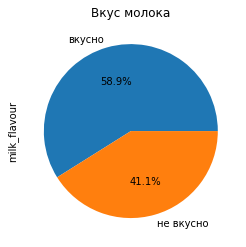

In [27]:
flavour_count = ferma.milk_flavour.value_counts()
print(flavour_count)
flavour_count.plot(kind='pie', title='Вкус молока', autopct='%1.1f%%')

Вкусно - 58.9%

Не вкусно - 41.1%

более_2_лет    518
менее_2_лет    110
Name: age, dtype: int64


<AxesSubplot:title={'center':'Возраст'}, ylabel='age'>

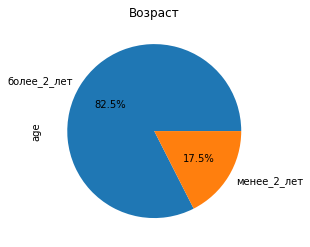

In [28]:
age_count = ferma.age.value_counts()
print(age_count)
age_count.plot(kind='pie', title='Возраст', autopct='%1.1f%%')

Большая часть коров старше 2 лет.

Барин       240
Буйный      214
Соловчик    110
Геркулес     64
Name: dads_name, dtype: int64


<AxesSubplot:title={'center':'Имя отца'}, ylabel='dads_name'>

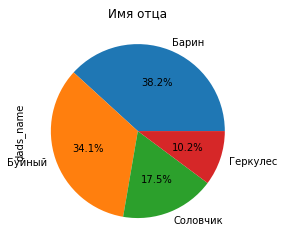

In [29]:
dads_name_count = ferma.dads_name.value_counts()
print(dads_name_count)
dads_name_count.plot(kind='pie', title='Имя отца', autopct='%1.1f%%')

Всего четыре разных имени отцов, Барин и Буйный - самые популярные из них.

РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: breed, dtype: int64


<AxesSubplot:title={'center':'Разные породы коров, которых планируется купить'}, ylabel='breed'>

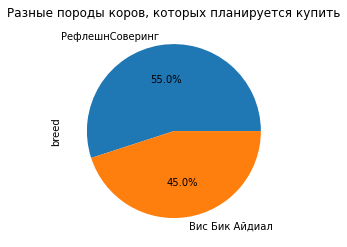

In [30]:
breed_count = cow_to_buy.breed.value_counts()
print(breed_count)
breed_count.plot(kind='pie', title='Разные породы коров, которых планируется купить', autopct='%1.1f%%')

Пород одинаковое количество

равнинное    11
холмистое     9
Name: pasture_type, dtype: int64


<AxesSubplot:title={'center':'Разные типы пастбищ коров, которых планируется купить'}, ylabel='pasture_type'>

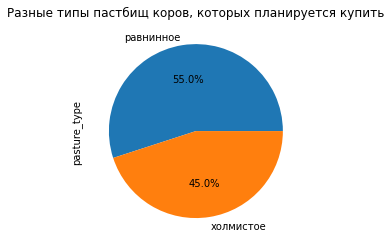

In [31]:
pasture_typecow_count = cow_to_buy.pasture_type.value_counts()
print(pasture_typecow_count)
pasture_typecow_count.plot(kind='pie', title='Разные типы пастбищ коров, которых планируется купить', autopct='%1.1f%%')

Равнинных и холмистых пастбищ равное количество

РефлешнСоверинг    12
Вис Бик Айдиал      8
Name: dads_breed, dtype: int64


<AxesSubplot:title={'center':'Разные породы отцов коров, которых планируется купить'}, ylabel='dads_breed'>

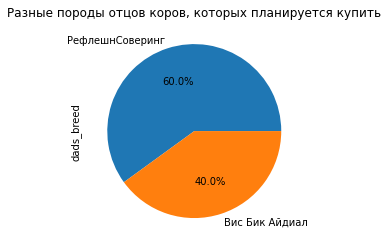

In [32]:
dads_breedcow_count = cow_to_buy.dads_breed.value_counts()
print(dads_breedcow_count)
dads_breedcow_count.plot(kind='pie', title='Разные породы отцов коров, которых планируется купить', autopct='%1.1f%%')

РефлешнСоверинг в полтора раза больше

Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: dads_name, dtype: int64


<AxesSubplot:title={'center':'Разные имена отцов коров, которых планируется купить'}, ylabel='dads_name'>

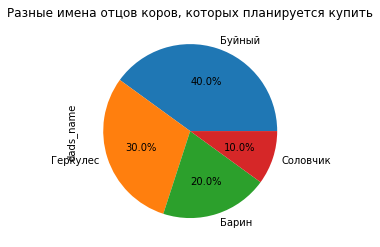

In [33]:
dads_namecow_count = cow_to_buy.dads_name.value_counts()
print(dads_namecow_count)
dads_namecow_count.plot(kind='pie', title='Разные имена отцов коров, которых планируется купить', autopct='%1.1f%%')

Буйный и Геркулес самые популярные имена.

более_2_лет    15
менее_2_лет     5
Name: age, dtype: int64


<AxesSubplot:title={'center':'Разный возраст коров, которых планируется купить'}, ylabel='age'>

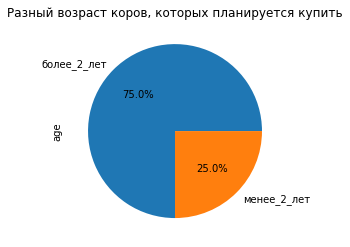

In [34]:
agecow_count = cow_to_buy.age.value_counts()
print(agecow_count)
agecow_count.plot(kind='pie', title='Разный возраст коров, которых планируется купить', autopct='%1.1f%%')

Коров старше 2 лет больше в полтора раза

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: fat_content, dtype: float64


<AxesSubplot:title={'center':'Жирность в %'}, xlabel='Жирность в %', ylabel='Количество'>

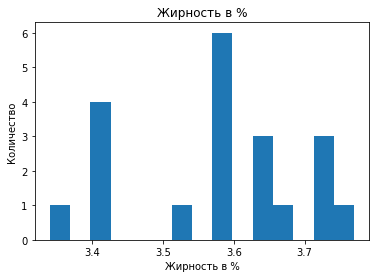

In [35]:
print(cow_to_buy['fat_content'].describe())
plot7 = cow_to_buy['fat_content'].plot(kind='hist',bins = 15, title='Жирность в %')
plt.xlabel("Жирность в %")
plt.ylabel("Количество")
plot7

Самой часто встречающейся является жирность в 3.4%, остальные показатели примерно на одном уровне 

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: protein_content, dtype: float64


<AxesSubplot:title={'center':'Содержание белка в %'}, xlabel='Содержание белка в %', ylabel='Количество'>

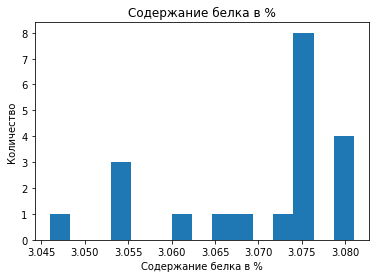

In [36]:
print(cow_to_buy['protein_content'].describe())
plot8 = cow_to_buy['protein_content'].plot(kind='hist',bins = 15, title='Содержание белка в %')
plt.xlabel("Содержание белка в %")
plt.ylabel("Количество")
plot8

Чаще всего встречается содержание белка в 3.075% и 3.08%.

**Вывод:**

В результате работы в разделе "Исследовательский анализ данных" были проанализированы все столбцы каждой из трех таблиц. В процессе анализы было выявлено аномальное значение в столбце с удоем, обнаружены ошибки при записи типов пастбищ, обнаружен неверный тип данных в нескольких столбцах. Все эти ошибки были ликвидированы в разделе с предобработкой данных. При анализе графиков и основных статистических показателей, сложилась картина данных в каждом из столбцов, что поможет при работе в следующих разделах.


## Корреляционный анализ

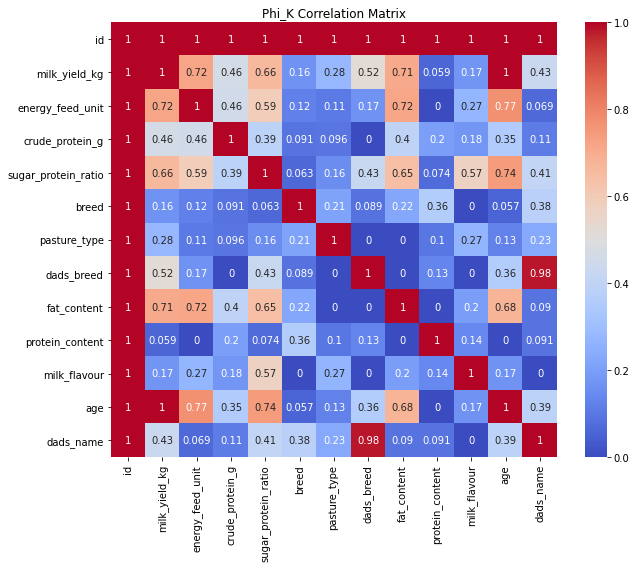

In [37]:
corr_matrix = ferma.phik_matrix(interval_cols=['milk_yield_kg', 
                    'energy_feed_unit', 'crude_protein_g', 'sugar_protein_ratio', 'fat_content', 'protein_content'])
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

Text(0, 0.5, 'Энергетическая кормовая единица')

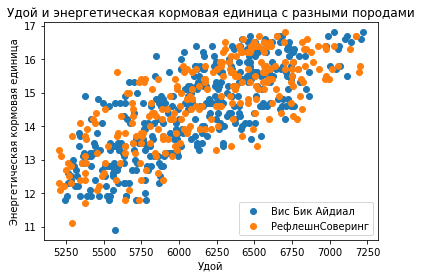

In [38]:
_ = plt.scatter(ferma[ferma['breed']=='Вис Бик Айдиал'].milk_yield_kg, ferma[ferma['breed']=='Вис Бик Айдиал'].energy_feed_unit)
_ = plt.scatter(ferma[ferma['breed']=='РефлешнСоверинг'].milk_yield_kg, ferma[ferma['breed']=='РефлешнСоверинг'].energy_feed_unit)
plt.title('Удой и энергетическая кормовая единица с разными породами')
plt.xlabel("Удой")
plt.legend(['Вис Бик Айдиал', 'РефлешнСоверинг'])
plt.ylabel("Энергетическая кормовая единица")

Заметна явная положительная корреляция удоя и энергетической кормовой единицы у обеих пород. 

Text(0, 0.5, 'Энергетическая кормовая единица')

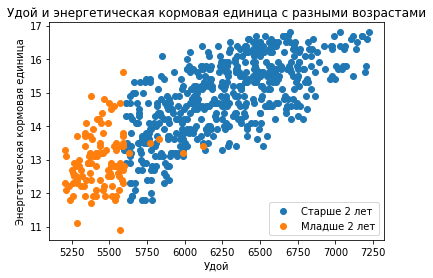

In [39]:
_ = plt.scatter(ferma[ferma['age']=='более_2_лет'].milk_yield_kg, ferma[ferma['age']=='более_2_лет'].energy_feed_unit)
_ = plt.scatter(ferma[ferma['age']=='менее_2_лет'].milk_yield_kg, ferma[ferma['age']=='менее_2_лет'].energy_feed_unit)
plt.title('Удой и энергетическая кормовая единица с разными возрастами')
plt.xlabel("Удой")
plt.legend(['Старше 2 лет', 'Младше 2 лет'])
plt.ylabel("Энергетическая кормовая единица")

Из данного графика видно, что показатели удоя у коров моложе 2 лет меньше чем у коров старше двух лет. Видна четкая граница между первой и второй категорией, исходя из чего можно предположить, что с продолением возраста в два года удой выходит на нормальные показатели.

Text(0, 0.5, 'Энергетическая кормовая единица')

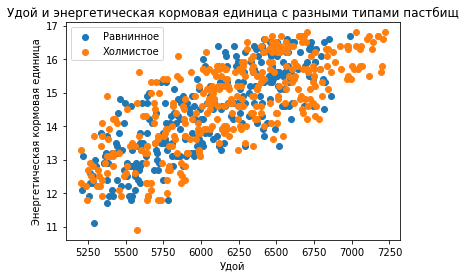

In [40]:
_ = plt.scatter(ferma[ferma['pasture_type']=='равнинное'].milk_yield_kg, ferma[ferma['pasture_type']=='равнинное'].energy_feed_unit)
_ = plt.scatter(ferma[ferma['pasture_type']=='холмистое'].milk_yield_kg, ferma[ferma['pasture_type']=='холмистое'].energy_feed_unit)
plt.title('Удой и энергетическая кормовая единица с разными типами пастбищ')
plt.xlabel("Удой")
plt.legend(['Равнинное', 'Холмистое'])
plt.ylabel("Энергетическая кормовая единица")

Text(0, 0.5, 'Сахарно-протеиновое соотношение')

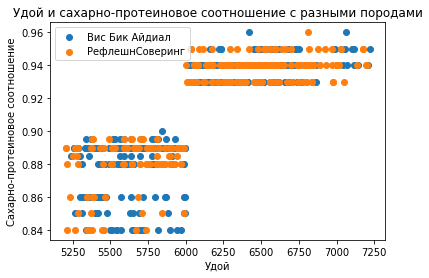

In [41]:
_ = plt.scatter(ferma[ferma['breed']=='Вис Бик Айдиал'].milk_yield_kg, ferma[ferma['breed']=='Вис Бик Айдиал'].sugar_protein_ratio)
_ = plt.scatter(ferma[ferma['breed']=='РефлешнСоверинг'].milk_yield_kg, ferma[ferma['breed']=='РефлешнСоверинг'].sugar_protein_ratio)
plt.title('Удой и сахарно-протеиновое соотношение с разными породами')
plt.xlabel("Удой")
plt.legend(['Вис Бик Айдиал', 'РефлешнСоверинг'])
plt.ylabel("Сахарно-протеиновое соотношение")

Text(0, 0.5, 'Сахарно-протеиновое соотношение')

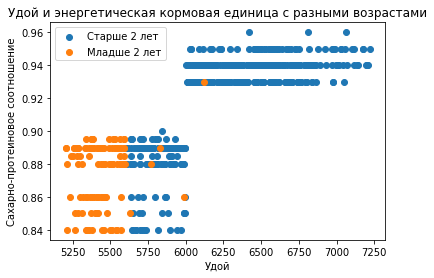

In [42]:
_ = plt.scatter(ferma[ferma['age']=='более_2_лет'].milk_yield_kg, ferma[ferma['age']=='более_2_лет'].sugar_protein_ratio)
_ = plt.scatter(ferma[ferma['age']=='менее_2_лет'].milk_yield_kg, ferma[ferma['age']=='менее_2_лет'].sugar_protein_ratio)
plt.title('Удой и энергетическая кормовая единица с разными возрастами')
plt.xlabel("Удой")
plt.legend(['Старше 2 лет', 'Младше 2 лет'])
plt.ylabel("Сахарно-протеиновое соотношение")

In [43]:
ferma.head(10)

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,вкусно,менее_2_лет,Барин
5,6.0,5254.0,12.7,1806.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.13,3.078,вкусно,менее_2_лет,Барин
6,7.0,5910.0,13.2,1792.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.48,3.077,вкусно,более_2_лет,Соловчик
7,8.0,6179.0,14.7,1806.0,0.930,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.55,3.076,вкусно,более_2_лет,Геркулес
8,9.0,6783.0,14.2,1918.0,0.940,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.71,3.077,вкусно,более_2_лет,Буйный
9,10.0,5339.0,13.4,1791.0,0.895,Вис Бик Айдиал,холмистое,РефлешнСоверинг,3.13,3.075,вкусно,менее_2_лет,Барин


Text(0, 0.5, 'Сырой протеин')

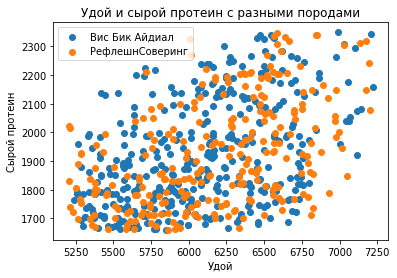

In [44]:
_ = plt.scatter(ferma[ferma['breed']=='Вис Бик Айдиал'].milk_yield_kg, ferma[ferma['breed']=='Вис Бик Айдиал'].crude_protein_g)
_ = plt.scatter(ferma[ferma['breed']=='РефлешнСоверинг'].milk_yield_kg, ferma[ferma['breed']=='РефлешнСоверинг'].crude_protein_g)
plt.title('Удой и сырой протеин с разными породами')
plt.xlabel("Удой")
plt.legend(['Вис Бик Айдиал', 'РефлешнСоверинг'])
plt.ylabel("Сырой протеин")

Видна слабая корреляция вне зависимости от породы.

Text(0, 0.5, 'Жирность')

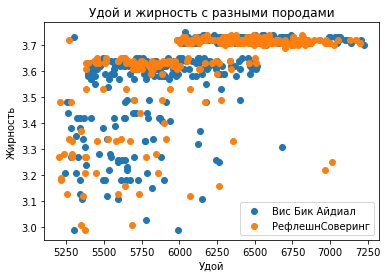

In [45]:
_ = plt.scatter(ferma[ferma['breed']=='Вис Бик Айдиал'].milk_yield_kg, ferma[ferma['breed']=='Вис Бик Айдиал'].fat_content)
_ = plt.scatter(ferma[ferma['breed']=='РефлешнСоверинг'].milk_yield_kg, ferma[ferma['breed']=='РефлешнСоверинг'].fat_content)
plt.title('Удой и жирность с разными породами')
plt.xlabel("Удой")
plt.legend(['Вис Бик Айдиал', 'РефлешнСоверинг'])
plt.ylabel("Жирность")

Text(0, 0.5, 'Жирность')

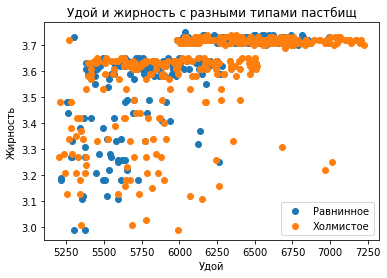

In [46]:
_ = plt.scatter(ferma[ferma['pasture_type']=='равнинное'].milk_yield_kg, ferma[ferma['pasture_type']=='равнинное'].fat_content)
_ = plt.scatter(ferma[ferma['pasture_type']=='холмистое'].milk_yield_kg, ferma[ferma['pasture_type']=='холмистое'].fat_content)
plt.title('Удой и жирность с разными типами пастбищ')
plt.xlabel("Удой")
plt.legend(['Равнинное', 'Холмистое'])
plt.ylabel("Жирность")

В результате корреляционного анализа можно сделать следующие выводы:

1) Сильная зависимость с целевым признаком заметна у энергетической кормовой единицы и сахарно-протеинового соотношения, у остальных признаков, за исключением содержания белка, слабая зависимость.

2) У содержания белка слабая зависимость со всеми признаками и целевой переменной.

3) У энергетической кормовой единицы и сахарно-протеинового соотношения сильная зависимость, что свидетельствовует о мультиколлинеарности.

4) Порода и тип пастбищ не влияют на зависимость входных и целевого признаков.

5) Коровы младше двух лет, за исключением единичных случаев, не дают удой больше 6000кг, но по ходу взросления выходят на нормальные показатели.

## Обучение модели линейной регрессии

In [47]:
X = ferma.drop(['id', 'sugar_protein_ratio', 'dads_name', 'milk_yield_kg', 'milk_flavour', 'protein_content'], axis=1)
y = ferma['milk_yield_kg']

Принято решение использовать как входные признаки все колонки кроме 'id', 'sugar_protein_ratio', 'dads_name', 'protein_content' id никак не влияет на удой, 'sugar_protein_ratio' убран чтобы избежать мультиколлинеарности, dads_name будет использоваться только в третьей модели, а protein_content имеет околонулевую корреяцию с целевым признаком.

In [48]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
print(X_train.info())
print(y_train.shape)
ferma

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy_feed_unit  471 non-null    float64
 1   crude_protein_g   471 non-null    float64
 2   breed             471 non-null    object 
 3   pasture_type      471 non-null    object 
 4   dads_breed        471 non-null    object 
 5   fat_content       471 non-null    float64
 6   age               471 non-null    object 
dtypes: float64(3), object(4)
memory usage: 29.4+ KB
None
(471,)


,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,вкусно,менее_2_лет,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625.0,6812.0,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный
624,626.0,5513.0,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.073,вкусно,менее_2_лет,Барин
625,627.0,5970.0,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.64,3.075,не вкусно,более_2_лет,Барин
626,628.0,5746.0,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.077,вкусно,более_2_лет,Барин


In [49]:
cat_col_names = ['breed', 'pasture_type', 'dads_breed', 'age']
num_col_names = ['energy_feed_unit', 'crude_protein_g', 'fat_content']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

print(X_train.head())

   x0_РефлешнСоверинг  x1_холмистое  x2_РефлешнСоверинг  x3_менее_2_лет  \
0                 1.0           1.0                 1.0             0.0   
1                 1.0           1.0                 1.0             1.0   
2                 0.0           0.0                 0.0             0.0   
3                 0.0           1.0                 0.0             0.0   
4                 0.0           0.0                 0.0             0.0   

   energy_feed_unit  crude_protein_g  fat_content  
0          1.502378         1.079523     0.562532  
1         -1.557270        -0.196920    -1.601817  
2          0.125537        -1.386085    -2.563750  
3         -0.103937         0.752230     0.081565  
4         -1.098323         0.828598     0.201807  


In [50]:
model_lr_1  = LinearRegression()

model_lr_1.fit(X_train, y_train)

predictions = model_lr_1.predict(X_test)

r2 = r2_score(y_test, predictions)  
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions) 
rmse = mean_squared_error(y_test, predictions, squared=False) 

In [51]:
print('r2 -', r2)
print('mae -', mae)
print('mse -', mse)
print('rmse -', rmse)

r2 - 0.7100869199358714
mae - 188.31224940480325
mse - 59016.145851804584
rmse - 242.93238946629694


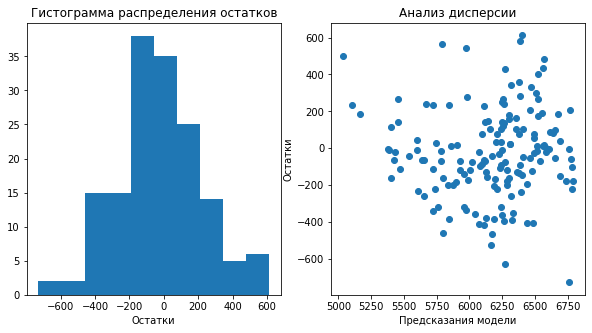

In [52]:
residuals = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

R^2 = 0.7179639624876066

Распределение остатков близко у нормальному, практически симметрично относительно нуля.

Анализ дисперсии показывает, что разница между минимумом и максимумом сильно отличается от нормы только на небольших значениях удоя. 

Модель очевидно нуждается в доработке, как из-за небольшого коэфицента детерминации так и из-за далеких от идеала распределения и дисперсии остатков.

Text(0, 0.5, 'Энергетическая кормовая единица')

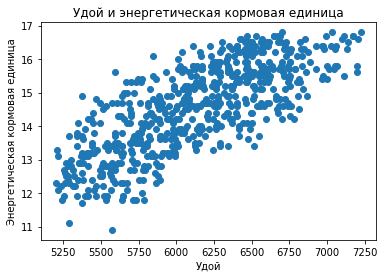

In [53]:
_ = plt.scatter(ferma.milk_yield_kg, ferma.energy_feed_unit)
plt.title('Удой и энергетическая кормовая единица')
plt.xlabel("Удой")
plt.ylabel("Энергетическая кормовая единица")

Text(0, 0.5, 'Сахарно-протеиновое соотношение')

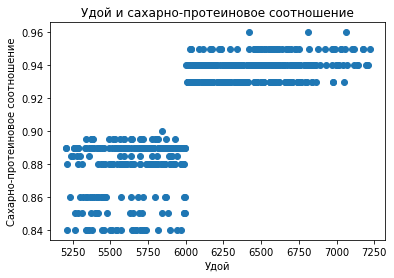

In [54]:
_ = plt.scatter(ferma.milk_yield_kg, ferma.sugar_protein_ratio)
plt.title('Удой и сахарно-протеиновое соотношение')
plt.xlabel("Удой")
plt.ylabel("Сахарно-протеиновое соотношение")

Text(0, 0.5, 'Жирность')

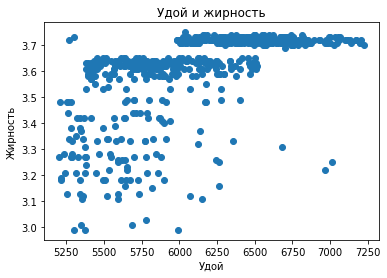

In [55]:
_ = plt.scatter(ferma.milk_yield_kg, ferma.fat_content)
plt.title('Удой и жирность')
plt.xlabel("Удой")
plt.ylabel("Жирность")

ЭКЕ связаны нелинейно, можем добавить признак ЭКЕ в квадрате.

Можно также заметить, что СПО и удой связаны нелинейно, данные как будто разбиты на группы, а значит мы можем использовать СПО как категориальный признак. Такие же проблема и решение заметны у признака Жирность.

In [56]:
ferma['energy_feed_unit_squared'] = ferma['energy_feed_unit']**2
ferma 

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name,energy_feed_unit_squared
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,201.64
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик,163.84
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин,196.00
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,153.76
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,вкусно,менее_2_лет,Барин,163.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625.0,6812.0,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный,237.16
624,626.0,5513.0,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.073,вкусно,менее_2_лет,Барин,166.41
625,627.0,5970.0,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.64,3.075,не вкусно,более_2_лет,Барин,207.36
626,628.0,5746.0,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.077,вкусно,более_2_лет,Барин,190.44


In [57]:
ferma['sugar_protein_ratio_type'] = 'Среднее'
ferma.loc[ferma['sugar_protein_ratio'] > 0.92, 'sugar_protein_ratio_type'] = 'Высокое'
ferma.loc[ferma['sugar_protein_ratio'] < 0.87, 'sugar_protein_ratio_type'] = 'Низкое'
ferma

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name,energy_feed_unit_squared,sugar_protein_ratio_type
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,201.64,Среднее
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик,163.84,Среднее
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин,196.00,Среднее
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,153.76,Среднее
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,вкусно,менее_2_лет,Барин,163.84,Среднее
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625.0,6812.0,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный,237.16,Высокое
624,626.0,5513.0,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.073,вкусно,менее_2_лет,Барин,166.41,Среднее
625,627.0,5970.0,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.64,3.075,не вкусно,более_2_лет,Барин,207.36,Среднее
626,628.0,5746.0,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.077,вкусно,более_2_лет,Барин,190.44,Среднее


In [58]:
ferma['fat_content_type'] = 'Среднее'
ferma.loc[ferma['fat_content'] > 3.65, 'fat_content_type'] = 'Высокое'
ferma.loc[ferma['fat_content'] < 3.5, 'fat_content_type'] = 'Низкое'
ferma

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный,201.64,Среднее,Среднее
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,вкусно,менее_2_лет,Соловчик,163.84,Среднее,Среднее
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,не вкусно,более_2_лет,Барин,196.00,Среднее,Среднее
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный,153.76,Среднее,Низкое
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,вкусно,менее_2_лет,Барин,163.84,Среднее,Высокое
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625.0,6812.0,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.74,3.075,не вкусно,более_2_лет,Буйный,237.16,Высокое,Высокое
624,626.0,5513.0,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.073,вкусно,менее_2_лет,Барин,166.41,Среднее,Среднее
625,627.0,5970.0,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.64,3.075,не вкусно,более_2_лет,Барин,207.36,Среднее,Среднее
626,628.0,5746.0,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.077,вкусно,более_2_лет,Барин,190.44,Среднее,Среднее


In [59]:
X2 = ferma.drop(['id', 'sugar_protein_ratio', 'dads_name', 'milk_flavour',
                 'milk_yield_kg', 'protein_content', 'energy_feed_unit', 'sugar_protein_ratio', 'fat_content'], axis=1)
y2 = ferma['milk_yield_kg']

In [60]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=RANDOM_STATE)
print(X_train.info())
print(y_train.shape)
X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   crude_protein_g           471 non-null    float64
 1   breed                     471 non-null    object 
 2   pasture_type              471 non-null    object 
 3   dads_breed                471 non-null    object 
 4   age                       471 non-null    object 
 5   energy_feed_unit_squared  471 non-null    float64
 6   sugar_protein_ratio_type  471 non-null    object 
 7   fat_content_type          471 non-null    object 
dtypes: float64(2), object(6)
memory usage: 33.1+ KB
None
(471,)


,crude_protein_g,breed,pasture_type,dads_breed,age,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type
507,2123.0,РефлешнСоверинг,холмистое,РефлешнСоверинг,более_2_лет,272.25,Высокое,Высокое
382,1889.0,РефлешнСоверинг,холмистое,РефлешнСоверинг,менее_2_лет,156.25,Среднее,Низкое
586,1671.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,216.09,Среднее,Низкое
196,2063.0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,более_2_лет,207.36,Высокое,Среднее
327,2077.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,171.61,Среднее,Среднее
...,...,...,...,...,...,...,...,...
71,2212.0,РефлешнСоверинг,холмистое,Вис Бик Айдиал,более_2_лет,187.69,Среднее,Среднее
106,1742.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,222.01,Высокое,Высокое
270,1775.0,РефлешнСоверинг,равнинное,Вис Бик Айдиал,более_2_лет,179.56,Среднее,Среднее
435,1949.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,171.61,Среднее,Среднее


In [61]:
cat_col_names2 = ['breed', 'pasture_type', 'dads_breed', 'age', 'sugar_protein_ratio_type', 'fat_content_type']
num_col_names2 = ['energy_feed_unit_squared', 'crude_protein_g']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names2])
X_test_scaled = scaler.transform(X_test[num_col_names2])
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names2])
X_test_ohe = encoder.transform(X_test[cat_col_names2])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names2)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names2)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_РефлешнСоверинг,x3_менее_2_лет,x4_Низкое,x4_Среднее,x5_Низкое,x5_Среднее,energy_feed_unit_squared,crude_protein_g
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.577968,1.079523
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.511438,-0.196920
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.082269,-1.386085
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.150235,0.752230
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-1.102358,0.828598


In [62]:
model_lr_2  = LinearRegression()

model_lr_2.fit(X_train, y_train)

predictions = model_lr_2.predict(X_test)

r2 = r2_score(y_test, predictions)  
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions) 
rmse = mean_squared_error(y_test, predictions, squared=False)

In [63]:
print('r2 -', r2)
print('mae -', mae)
print('mse -', mse)
print('rmse -', rmse)

r2 - 0.8110535658361288
mae - 149.29467857206978
mse - 38462.87416327282
rmse - 196.1195404932227


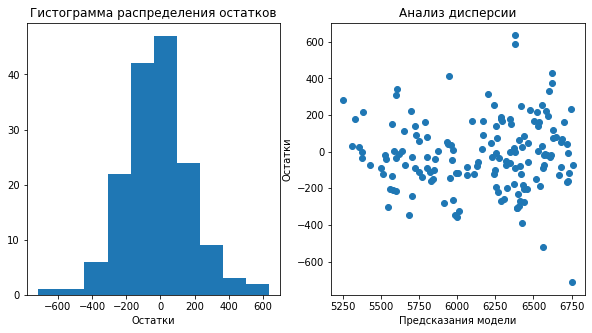

In [64]:
residuals = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

В результате изменений во второй модели мы получили более хороший показатель r2 (0.8139). Распределение и дисперсия остатков также стали приемлемей, чем ранее. При анализу дисперсии видно, что при небольшом удое результаты значительно улучшились.

In [65]:
X3 = ferma.drop(['id', 'sugar_protein_ratio',
                 'milk_yield_kg', 'protein_content', 'milk_flavour', 'energy_feed_unit', 'sugar_protein_ratio', 'fat_content'], axis=1)
y3 = ferma['milk_yield_kg']

In [66]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X3, y3, random_state=RANDOM_STATE)
print(X_train.info())
print(y_train.shape)
X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   crude_protein_g           471 non-null    float64
 1   breed                     471 non-null    object 
 2   pasture_type              471 non-null    object 
 3   dads_breed                471 non-null    object 
 4   age                       471 non-null    object 
 5   dads_name                 471 non-null    object 
 6   energy_feed_unit_squared  471 non-null    float64
 7   sugar_protein_ratio_type  471 non-null    object 
 8   fat_content_type          471 non-null    object 
dtypes: float64(2), object(7)
memory usage: 36.8+ KB
None
(471,)


,crude_protein_g,breed,pasture_type,dads_breed,age,dads_name,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type
507,2123.0,РефлешнСоверинг,холмистое,РефлешнСоверинг,более_2_лет,Соловчик,272.25,Высокое,Высокое
382,1889.0,РефлешнСоверинг,холмистое,РефлешнСоверинг,менее_2_лет,Барин,156.25,Среднее,Низкое
586,1671.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,Буйный,216.09,Среднее,Низкое
196,2063.0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,более_2_лет,Буйный,207.36,Высокое,Среднее
327,2077.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,Геркулес,171.61,Среднее,Среднее
...,...,...,...,...,...,...,...,...,...
71,2212.0,РефлешнСоверинг,холмистое,Вис Бик Айдиал,более_2_лет,Барин,187.69,Среднее,Среднее
106,1742.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,Геркулес,222.01,Высокое,Высокое
270,1775.0,РефлешнСоверинг,равнинное,Вис Бик Айдиал,более_2_лет,Геркулес,179.56,Среднее,Среднее
435,1949.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,более_2_лет,Буйный,171.61,Среднее,Среднее


In [67]:
cat_col_names2 = ['breed', 'pasture_type', 'dads_breed', 'age', 'dads_name', 'sugar_protein_ratio_type', 'fat_content_type']
num_col_names2 = ['energy_feed_unit_squared', 'crude_protein_g']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names2])
X_test_scaled = scaler.transform(X_test[num_col_names2])
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names2])
X_test_ohe = encoder.transform(X_test[cat_col_names2])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names2)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names2)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_РефлешнСоверинг,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_Низкое,x5_Среднее,x6_Низкое,x6_Среднее,energy_feed_unit_squared,crude_protein_g
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.577968,1.079523
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.511438,-0.196920
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.082269,-1.386085
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.150235,0.752230
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1.102358,0.828598


In [68]:
model_lr_3  = LinearRegression()

model_lr_3.fit(X_train, y_train)

predictions = model_lr_3.predict(X_test)

r2 = r2_score(y_test, predictions) 
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions) 
rmse = mean_squared_error(y_test, predictions, squared=False)

In [69]:
print('r2 -', r2)
print('mae -', mae)
print('mse -', mse)
print('rmse -', rmse)

r2 - 0.8181520034341098
mae - 150.65678388527908
mse - 37017.88096562297
rmse - 192.40031435947023


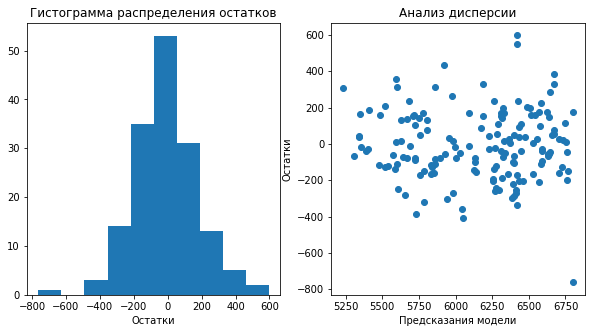

In [70]:
residuals = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

In [71]:
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)
print('Доверительный интервал')
print('Нижняя граница -', lower_bound)
print('Верхняя граница -', upper_bound)

Доверительный интервал
Нижняя граница - 5349.209556605476
Верхняя граница - 6759.778831691476


Третья модель показала лучший результат r2, а так же самое нормальное распределение остатков и самые лучшие показатели анализа дисперсии.

**Показатели каждой из моделей:**

**Первая модель:**

r2 - 0.7100869199358714

mae - 188.31224940480325

mse - 59016.145851804584

rmse - 242.93238946629694

**Вторая модель:**

r2 - 0.8110535658361288

mae - 149.29467857206978

mse - 38462.87416327282

rmse - 196.1195404932227

**Третья модель:**

r2 - 0.8181520034341098

mae - 150.65678388527908

mse - 37017.88096562297

rmse - 192.40031435947023

**Доверительный интервал для лучшей модели:**

Нижняя граница - 5349.209556605476

Верхняя граница - 6759.778831691476

Основываясь на метриках, анализе остатков и дисперсионном анализе можно сделать вывод, что лучшей их трех моделей является третья. Ее остатки распределены нормально с центром в 0, а все метрики кроме mae показывают лучший результат, а mae имеет практически такое же значение как и у второй модели. 

In [72]:
cow_to_buy['energy_feed_unit'] = ferma['energy_feed_unit'].mean() * 1.05
cow_to_buy['crude_protein_g'] = ferma['crude_protein_g'].mean() * 1.05
cow_to_buy['sugar_protein_ratio'] = ferma['sugar_protein_ratio'].mean() * 1.05
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744
1,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744
2,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744
3,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744
4,РефлешнСоверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744
5,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744
7,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744
8,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744


Добавили недостающие столбцы в датасет с коровами для покупки.

In [73]:
cow_to_buy['energy_feed_unit_squared'] = cow_to_buy['energy_feed_unit']**2 
cow_to_buy['sugar_protein_ratio_type'] = 'Среднее'
cow_to_buy.loc[cow_to_buy['sugar_protein_ratio'] > 0.92, 'sugar_protein_ratio_type'] = 'Высокое'
cow_to_buy.loc[cow_to_buy['sugar_protein_ratio'] < 0.87, 'sugar_protein_ratio_type'] = 'Низкое'
cow_to_buy['fat_content_type'] = 'Среднее'
cow_to_buy.loc[cow_to_buy['fat_content'] > 3.65, 'fat_content_type'] = 'Высокое'
cow_to_buy.loc[cow_to_buy['fat_content'] < 3.5, 'fat_content_type'] = 'Низкое'
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
1,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
2,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
3,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое
4,РефлешнСоверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
5,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
7,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
8,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое


In [74]:
X_train = cow_to_buy.drop(['sugar_protein_ratio', 'protein_content', 'energy_feed_unit', 'fat_content'], axis=1)

cat_col_names2 = ['breed', 'pasture_type', 'dads_breed', 'age', 'dads_name', 'sugar_protein_ratio_type', 'fat_content_type']
num_col_names2 = ['energy_feed_unit_squared', 'crude_protein_g']

X_train_scaled = scaler.transform(X_train[num_col_names2])
X_train_ohe = encoder.transform(X_train[cat_col_names2])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names2)

X_train_for_class = pd.concat([X_train_ohe, X_train_scaled], axis=1)

X_train_for_class['x5_Низкое'] = 0.0
X_train_for_class['x5_Среднее'] = 0.0

Добавил две колонки, потому что в колонке sugar_protein_ratio_type все значение равны Высокое и при кодировке эта колонка не учитывается, что приводит к ошибкам при использовании модели(не совпадает количество колонок). 

In [75]:
predictions = model_lr_3.predict(X_train_for_class)
predictions

array([6421.30763646, 6171.5045568 , 6045.23090042, 6394.86943292,
       6336.43703552, 6174.34664569, 6421.30763646, 6372.96548691,
       6045.23090042, 6193.4085028 , 6386.85632846, 6627.08718966,
       6672.58725032, 5905.61185357, 6045.23090042, 6394.86943292,
       6386.85632846, 6425.62625955, 6356.18834401, 6336.43703552])

In [76]:
cow_to_buy['milk_yield_predicted'] = predictions
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type,milk_yield_predicted
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6421.307636
1,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6171.504557
2,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6045.230900
3,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6394.869433
4,РефлешнСоверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6336.437036
5,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6174.346646
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6421.307636
7,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6372.965487
8,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6045.230900
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6193.408503


**Вывод:**

Были созданы три модели линейной регрессии, затем было проведено сравнение результатов их работы по метрикам и анализу остатков. Выяснено, что третья модель самая эффективная, поэтому после подготовки данных она была использована для предсказания удоя коров ЭкоФермы. Основываясь на этих данных в дальнейшем можно будет принять решение о покупке.

## Обучение модели логистической регрессии

In [77]:
le = LabelEncoder()
ferma['milk_flavour']
mapping = {'вкусно': 1, 'не вкусно': 0}
categories_mapped = [mapping[category] if category in mapping else category for category in ferma['milk_flavour']]
ferma['milk_flavour'] = le.fit_transform(categories_mapped)
ferma

,id,milk_yield_kg,energy_feed_unit,crude_protein_g,sugar_protein_ratio,breed,pasture_type,dads_breed,fat_content,protein_content,milk_flavour,age,dads_name,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type
0,1.0,5863.0,14.2,1743.0,0.890,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.58,3.076,1,более_2_лет,Буйный,201.64,Среднее,Среднее
1,2.0,5529.0,12.8,2138.0,0.890,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.54,3.079,1,менее_2_лет,Соловчик,163.84,Среднее,Среднее
2,3.0,5810.0,14.0,1854.0,0.885,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.59,3.074,0,более_2_лет,Барин,196.00,Среднее,Среднее
3,4.0,5895.0,12.4,2012.0,0.885,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.40,3.075,0,более_2_лет,Буйный,153.76,Среднее,Низкое
4,5.0,5302.0,12.8,1675.0,0.885,Вис Бик Айдиал,равнинное,РефлешнСоверинг,3.73,3.073,1,менее_2_лет,Барин,163.84,Среднее,Высокое
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625.0,6812.0,15.4,1964.0,0.940,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.74,3.075,0,более_2_лет,Буйный,237.16,Высокое,Высокое
624,626.0,5513.0,12.9,1700.0,0.880,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.073,1,менее_2_лет,Барин,166.41,Среднее,Среднее
625,627.0,5970.0,14.4,1837.0,0.880,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.64,3.075,0,более_2_лет,Барин,207.36,Среднее,Среднее
626,628.0,5746.0,13.8,1994.0,0.890,РефлешнСоверинг,равнинное,РефлешнСоверинг,3.64,3.077,1,более_2_лет,Барин,190.44,Среднее,Среднее


Заменил вкусно на 1, а не вкусно на 0 в колонке milk_flavour

In [78]:
X5 = ferma.drop(['id',
                 'milk_yield_kg', 'fat_content', 'sugar_protein_ratio', 'energy_feed_unit'], axis=1)
y5 = ferma['milk_flavour']

In [79]:
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X5, y5, random_state=RANDOM_STATE)
print(X_train.info())
print(y_train.shape)
X_train

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471 entries, 507 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   crude_protein_g           471 non-null    float64
 1   breed                     471 non-null    object 
 2   pasture_type              471 non-null    object 
 3   dads_breed                471 non-null    object 
 4   protein_content           471 non-null    float64
 5   milk_flavour              471 non-null    int64  
 6   age                       471 non-null    object 
 7   dads_name                 471 non-null    object 
 8   energy_feed_unit_squared  471 non-null    float64
 9   sugar_protein_ratio_type  471 non-null    object 
 10  fat_content_type          471 non-null    object 
dtypes: float64(3), int64(1), object(7)
memory usage: 44.2+ KB
None
(471,)


,crude_protein_g,breed,pasture_type,dads_breed,protein_content,milk_flavour,age,dads_name,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type
507,2123.0,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.074,1,более_2_лет,Соловчик,272.25,Высокое,Высокое
382,1889.0,РефлешнСоверинг,холмистое,РефлешнСоверинг,3.072,1,менее_2_лет,Барин,156.25,Среднее,Низкое
586,1671.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.079,0,более_2_лет,Буйный,216.09,Среднее,Низкое
196,2063.0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,3.079,1,более_2_лет,Буйный,207.36,Высокое,Среднее
327,2077.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.076,1,более_2_лет,Геркулес,171.61,Среднее,Среднее
...,...,...,...,...,...,...,...,...,...,...,...
71,2212.0,РефлешнСоверинг,холмистое,Вис Бик Айдиал,3.077,1,более_2_лет,Барин,187.69,Среднее,Среднее
106,1742.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.073,1,более_2_лет,Геркулес,222.01,Высокое,Высокое
270,1775.0,РефлешнСоверинг,равнинное,Вис Бик Айдиал,3.071,1,более_2_лет,Геркулес,179.56,Среднее,Среднее
435,1949.0,Вис Бик Айдиал,равнинное,Вис Бик Айдиал,3.075,0,более_2_лет,Буйный,171.61,Среднее,Среднее


In [80]:
cat_col_names2 = ['breed', 'pasture_type', 'dads_breed', 'age', 'dads_name', 'sugar_protein_ratio_type', 'fat_content_type']
num_col_names2 = ['energy_feed_unit_squared', 'crude_protein_g', 'protein_content']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names2])
X_test_scaled = scaler.transform(X_test[num_col_names2])
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names2])
X_test_ohe = encoder.transform(X_test[cat_col_names2])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names2)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names2)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_РефлешнСоверинг,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_Низкое,x5_Среднее,x6_Низкое,x6_Среднее,energy_feed_unit_squared,crude_protein_g,protein_content
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.577968,1.079523,-0.679069
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,-1.511438,-0.196920,-1.452568
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.082269,-1.386085,1.254677
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.150235,0.752230,1.254677
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,-1.102358,0.828598,0.094429


In [81]:
clf = LogisticRegression()

clf = clf.fit(X_train, y_train)


y_pred_prob = clf.predict_proba(X_test)[:, 1]

threshold = 0.82

predictions = (y_pred_prob > threshold).astype(int)


<AxesSubplot:>

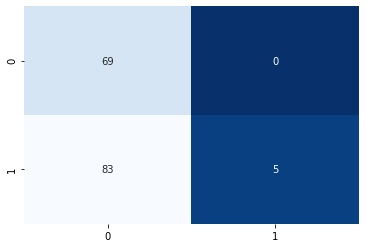

In [82]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r', cbar=False)

In [83]:
acc = accuracy_score(predictions, y_test)
recall = recall_score(y_test, predictions)
precision = precision_score(y_test, predictions)

print('accuracy: ',round(acc ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))

accuracy:  0.471
recall:  0.057
precision:  1.0


Для нас важнее ошибка первого рода, потому что не страшно предсказать что молоко не вкусно, когда оно на самом деле вкусно, но страшно предсказать, что оно вкусно, когда оно не вкусно, так как для фермера критически важно, чтобы у всех купленных коров было вкусное молоко. Значит большее внимание стоит обратить на метрику precision. Я изменил значение порога на 0.78, чтобы свести вероятность допустить ошибку первого порядка к минимуму. Это модель хорошо подходит для наших задач, она точно определяет вкусное молоко, а значит фермер не купит по ошибке корову с невкусным молоком. Далее используем эту модель на данных с коровами для покупки.

In [84]:
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type,milk_yield_predicted
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6421.307636
1,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6171.504557
2,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6045.230900
3,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6394.869433
4,РефлешнСоверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6336.437036
5,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6174.346646
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6421.307636
7,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6372.965487
8,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6045.230900
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6193.408503


In [85]:
X_train = cow_to_buy.drop(['sugar_protein_ratio', 'fat_content', 'energy_feed_unit'], axis=1)

cat_col_names2 = ['breed', 'pasture_type', 'dads_breed', 'age', 'dads_name', 'sugar_protein_ratio_type', 'fat_content_type']
num_col_names2 = ['energy_feed_unit_squared', 'crude_protein_g', 'protein_content']

X_train_scaled = scaler.transform(X_train[num_col_names2])

X_train_ohe = encoder.transform(X_train[cat_col_names2])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names2)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_train['x5_Низкое'] = 0.0
X_train['x5_Среднее'] = 0.0
X_train.head()

,x0_РефлешнСоверинг,x1_холмистое,x2_РефлешнСоверинг,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_Низкое,x5_Среднее,x6_Низкое,x6_Среднее,energy_feed_unit_squared,crude_protein_g,protein_content
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.542248,0.517384,0.094429
1,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.542248,0.517384,2.028176
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.542248,0.517384,-0.679069
3,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.542248,0.517384,-5.706810
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.542248,0.517384,-0.679069


In [86]:
y_pred_prob = clf.predict_proba(X_train)[:, 1]

threshold = 0.7

predictions = (y_pred_prob > threshold).astype(int)

predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

In [87]:
cow_to_buy["milk_flavour"] = predictions
cow_to_buy

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type,milk_yield_predicted,milk_flavour
0,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6421.307636,0
1,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.54,3.081,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6171.504557,0
2,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6045.230900,0
3,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6394.869433,0
4,РефлешнСоверинг,равнинное,Вис Бик Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6336.437036,0
5,РефлешнСоверинг,равнинное,РефлешнСоверинг,Геркулес,3.63,3.053,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6174.346646,0
6,Вис Бик Айдиал,холмистое,Вис Бик Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6421.307636,0
7,Вис Бик Айдиал,равнинное,РефлешнСоверинг,Буйный,3.57,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6372.965487,0
8,РефлешнСоверинг,равнинное,РефлешнСоверинг,Барин,3.59,3.074,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Среднее,6045.230900,0
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6193.408503,1


**Вывод:**

Была создана модель логистической регрессии, которая предсказывает вкус молока. Так как фермеру критично не купить корову с невкусным молоком, нужно сделать шанс ошибки первого порядка нулевым. Сделать это удалось при помощи установки порога в 0.82. В результате метрика precision стала равна нулю, а значит все молоко которое выбрано вкусным таковым и является. Далее модель была применена на данных с коровами для покупки и были выявлены пять кандидатов на покупку.

## Итоговые выводы

Давайте отберем коров для покупки по двум ключевым критериям удой больше 6000кг и вкусное молоко

In [88]:
display(cow_to_buy[(cow_to_buy['milk_yield_predicted'] > 6000) & (cow_to_buy['milk_flavour'] == 1)])

,breed,pasture_type,dads_breed,dads_name,fat_content,protein_content,age,energy_feed_unit,crude_protein_g,sugar_protein_ratio,energy_feed_unit_squared,sugar_protein_ratio_type,fat_content_type,milk_yield_predicted,milk_flavour
9,РефлешнСоверинг,холмистое,Вис Бик Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Низкое,6193.408503,1
16,Вис Бик Айдиал,холмистое,РефлешнСоверинг,Соловчик,3.73,3.079,более_2_лет,15.276162,2019.947532,0.958744,233.361138,Высокое,Высокое,6386.856328,1


**Для заказщика:**

В результате работы с данными и моделями машинного обучения удалось выявить оптимальных для покупки коров. Это две коровы из третьей таблицы. Для второй модели, модели логистической регрессии можно понизить порог, что позволит увеличить количество коров подходящих под параметры, но создаст риск, что корова с не вкусным молоком будет классифицирована как корова с вкусным. Сейчас такого риска нет, все рекомендованные коровы будут давать вкусное молоко.

Также хотел бы порекомендовать добавить в данные разбиение коров на различные группы в зависимости от жирности их молока, ЭКЕ и СПО их корма, потому что если посмотреть на графики по этим данным, то можно лекго выделить три группы для каждого из параметров. В будущем это облегчит задачу по анализу данных о коровах, а также облегчит задачу поиска различных закономерностей.

**Выводы о моделях:**

1) Линейная регрессия

При корреляционном анализе данных была выявлена возможная мультиколлинеарность из-за большой корреляции между двумя признаками. Для избежания переобучения было решено не использовать один из признаков при тренировке первой модели. Результат первой модели показал ее неэффективность из-за плохих показателей основных метрик и анализа остатков. Для второй модели был изменен подход к признакам, при помощи графиков было замечено, что некоторые признаки не имеют линейной зависимости с целевым признаком из-за чего не эффективны при обучении. Для борьбы с этой проблемой два признака были превращены в категориальные переменные, а третий был представлен в виде квадратных значений. Таким образом удалось значительно улучшить показатели второй модели и сделать их приемлемыми. Для работы с третьей моделью был добавлен еще один признак с именами отов коров, что также помогло немного улучшить показатели.

В результате, лучшей стала третья модель, которая и использовалась для прогнозирования удоя коров из списка для покупки. 

2) Логистическая регрессия

Данная модель использовалась для задачи классификации молока на вкусное и не вкусное. Были проведены стандартные процедуры, такие как стандартизация и кодирование, которые уже использовались при работе с линейной регрессией. Далее была проведена небольшаая работа с данными, после чего на них начала тренироваться модель. Учитывая требования заказщика, самым важным было точно определить коров с 100% вкусным молоком, что подвело к мысли, что нужно обращать внимание на ошибки первого порядка и метрику precision. Чтобы свести риски к минимуму была проведена работа с порогом классификации, что позволило достичь показателя метрики precision в 1.0. После настройки модели, она была использована для определения вкуса молока у коров из списка для покупки. Было обнаружено 5 коров имеющих вкусное молоко из 16 имеющихся в списке на покупку.

В результате работы двух моделей удалось выделять двух коров, подходящих для заказщика и удовлетворяющих всем его требованиям. Для возможного улучшения обеих моделей, можно принять следующие меры: увеличить объем данных(заимствовать данные у других фермеров), попробовать настройку модели путем изменения признаков.